In [1]:
import collections
import torch
import math 
from torch import nn
import plotly.graph_objects as go
from d2l.torch import d2l

生成数据

$$ y_i = 2sin(x_i) + x_{i}^{0.8}+\epsilon$$

In [2]:
n_train = 50
x_train, _ = torch.sort(torch.rand(n_train)  * 5)

def f(x):
    return 2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))
x_test = torch.arange(0, 5, 0.1)
y_truth = f(x_test)
n_test = len(x_test)

print('Train: ', x_train.shape,'-->' ,y_train.shape)
print('Test: ',x_test.shape,'-->' ,y_truth.shape)

Train:  torch.Size([50]) --> torch.Size([50])
Test:  torch.Size([50]) --> torch.Size([50])


可视化

In [3]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth','Pred'], xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5);


## 平均汇聚
$$ f(x) = \frac{1}{n}\sum_{i=1}^{n}y_i

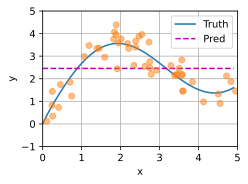

In [4]:
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

## 非参数注意力汇聚（池化）
- Nadaraya-Watson 核回归
$$ f(x) = \sum_{i=1}^{n}\frac{K(x-x_i)}{\sum_{j=1}^{n}K(x-x_j)}y_i$$
$$\Rightarrow $$
$$f(x)=\sum_{i=1}^{n}\alpha(x,x_i)y_i$$
权重
$$ \alpha(x,x_i) $$ 
上式子**K**取高斯核
$$K(u) = \frac{1}{\sqrt{2\pi}}\exp(-\frac{u^2}{2})$$
$$
\Rightarrow \begin{aligned}
f(x) &=\sum_{i=1}^{n} \alpha\left(x, x_{i}\right) y_{i} \\
&=\sum_{i=1}^{n} \frac{\exp \left(-\frac{1}{2}\left(x-x_{i}\right)^{2}\right)}{\sum_{j=1}^{n} \exp \left(-\frac{1}{2}\left(x-x_{j}\right)^{2}\right)} y_{i} \\
&=\sum_{i=1}^{n} \operatorname{softmax}\left(-\frac{1}{2}\left(x-x_{i}\right)^{2}\right) y_{i} .
\end{aligned}
$$

torch.Size([50, 50])


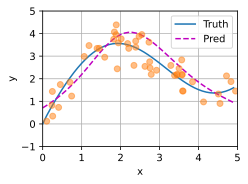

In [5]:
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
print(X_repeat.shape)
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2, dim=0)
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

注意力权重

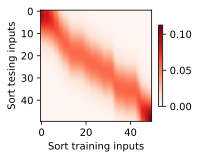

In [6]:
d2l.show_heatmaps(
    attention_weights.unsqueeze(0).unsqueeze(0),
    xlabel = 'Sort training inputs',
    ylabel = 'Sort tesing inputs'
)

# 参数注意力

批量矩阵乘法 torch.bmm

In [7]:
X = torch.ones((2,1,4))
Y = torch.ones((2,4,6))
torch.bmm(X, Y).shape

torch.Size([2, 1, 6])

带参数的注意力汇聚
$$

\begin{aligned}
f(x) &=\sum_{i=1}^{n} \alpha\left(x, x_{i}\right) y_{i} \\
&=\sum_{i=1}^{n} \frac{\exp \left(-\frac{1}{2}\left(\left(x-x_{i}\right) w\right)^{2}\right)}{\sum_{j=1}^{n} \exp \left(-\frac{1}{2}\left(\left(x-x_{j}\right) w\right)^{2}\right)} y_{i} \\
&=\sum_{i=1}^{n} \operatorname{softmax}\left(-\frac{1}{2}\left(\left(x-x_{i}\right) w\right)^{2}\right) y_{i}
\end{aligned}

$$

In [8]:
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))

    def forward(self, queries, keys, values):
         # queries 和 attention_weights 的形状为(查询个数，“键－值”对个数)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(-((queries - keys) * self.w)**2 / 2, dim=1)

        return torch.bmm(self.attention_weights.unsqueeze(1), 
                        values.unsqueeze(-1)).reshape(-1)


- `torch.eye()`
: 生成对角为1的矩阵

In [15]:
# X_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输入
X_tile = x_train.repeat((n_train, 1))
# Y_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输出
Y_tile = y_train.repeat((n_train, 1))
# keys的形状:('n_train'，'n_train'-1),将对角索引变成False，并去除了对角元素
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
# values的形状:('n_train'，'n_train'-1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

print(X_tile)
print(keys)

print(values.shape)

tensor([[0.1034, 0.2387, 0.2487,  ..., 4.7181, 4.8331, 4.9505],
        [0.1034, 0.2387, 0.2487,  ..., 4.7181, 4.8331, 4.9505],
        [0.1034, 0.2387, 0.2487,  ..., 4.7181, 4.8331, 4.9505],
        ...,
        [0.1034, 0.2387, 0.2487,  ..., 4.7181, 4.8331, 4.9505],
        [0.1034, 0.2387, 0.2487,  ..., 4.7181, 4.8331, 4.9505],
        [0.1034, 0.2387, 0.2487,  ..., 4.7181, 4.8331, 4.9505]])
tensor([[0.2387, 0.2487, 0.2573,  ..., 4.7181, 4.8331, 4.9505],
        [0.1034, 0.2487, 0.2573,  ..., 4.7181, 4.8331, 4.9505],
        [0.1034, 0.2387, 0.2573,  ..., 4.7181, 4.8331, 4.9505],
        ...,
        [0.1034, 0.2387, 0.2487,  ..., 4.5514, 4.8331, 4.9505],
        [0.1034, 0.2387, 0.2487,  ..., 4.5514, 4.7181, 4.9505],
        [0.1034, 0.2387, 0.2487,  ..., 4.5514, 4.7181, 4.8331]])
torch.Size([50, 49])


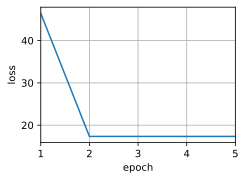

In [17]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

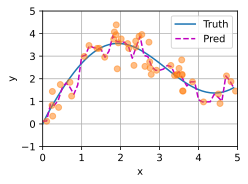

In [18]:
# keys的形状:(n_test，n_train)，每一行包含着相同的训练输入（例如，相同的键）
keys = x_train.repeat((n_test, 1))
# value的形状:(n_test，n_train)
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)